## 1. Data Overview <a class="anchor"  id="data_overview"></a>

In [2]:
# Import necessary modules
import numpy as np 
import pandas as pd 
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, OneHotEncoder
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from category_encoders.binary import BinaryEncoder

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv("/kaggle/input/credit-card-transactions/credit_card_transactions-ibm_v2.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24386900 entries, 0 to 24386899
Data columns (total 15 columns):
 #   Column          Dtype  
---  ------          -----  
 0   User            int64  
 1   Card            int64  
 2   Year            int64  
 3   Month           int64  
 4   Day             int64  
 5   Time            object 
 6   Amount          object 
 7   Use Chip        object 
 8   Merchant Name   int64  
 9   Merchant City   object 
 10  Merchant State  object 
 11  Zip             float64
 12  MCC             int64  
 13  Errors?         object 
 14  Is Fraud?       object 
dtypes: float64(1), int64(7), object(7)
memory usage: 2.7+ GB


In [8]:
latex_table = df.describe().to_latex(index=False, float_format="{:0.2f}".format)

# Print the LaTeX table code
print(latex_table)



\begin{tabular}{rrrrrrrr}
\toprule
User & Card & Year & Month & Day & Merchant Name & Zip & MCC \\
\midrule
24386900.00 & 24386900.00 & 24386900.00 & 24386900.00 & 24386900.00 & 24386900.00 & 21508765.00 & 24386900.00 \\
1001.02 & 1.35 & 2011.96 & 6.53 & 15.72 & -476922962771995648.00 & 50956.44 & 5561.17 \\
569.46 & 1.41 & 5.11 & 3.47 & 8.79 & 4758939870684008448.00 & 29397.07 & 879.32 \\
0.00 & 0.00 & 1991.00 & 1.00 & 1.00 & -9222899435637403648.00 & 501.00 & 1711.00 \\
510.00 & 0.00 & 2008.00 & 3.00 & 8.00 & -4500542936415012352.00 & 28374.00 & 5300.00 \\
1006.00 & 1.00 & 2013.00 & 7.00 & 16.00 & -794676495118551552.00 & 46742.00 & 5499.00 \\
1477.00 & 2.00 & 2016.00 & 10.00 & 23.00 & 3189517333335617024.00 & 77564.00 & 5812.00 \\
1999.00 & 8.00 & 2020.00 & 12.00 & 31.00 & 9223291803303717888.00 & 99928.00 & 9402.00 \\
\bottomrule
\end{tabular}



In [5]:
# Check the number of fraudulent transactions
df['Is Fraud?'].value_counts()

Is Fraud?
No     24357143
Yes       29757
Name: count, dtype: int64

In [6]:
# Check missing value by column
df.isnull().sum()

User                     0
Card                     0
Year                     0
Month                    0
Day                      0
Time                     0
Amount                   0
Use Chip                 0
Merchant Name            0
Merchant City            0
Merchant State     2720821
Zip                2878135
MCC                      0
Errors?           23998469
Is Fraud?                0
dtype: int64

## 2. Data Cleaning <a class="anchor"  id="data_cleaning"></a>

### (1) Amount <a class="anchor"  id="subsection1"></a>

In [7]:
df.Amount.head(5)

0    $134.09
1     $38.48
2    $120.34
3    $128.95
4    $104.71
Name: Amount, dtype: object

In [4]:
# We need to strip the '$' from the Amount to cast as a float
df["Amount"]=df["Amount"].str.replace("$","").astype(float)

In [8]:
# Now, we have transformed the datatype of Amount from object to float
df.Amount.head(5)

0    134.09
1     38.48
2    120.34
3    128.95
4    104.71
Name: Amount, dtype: float64

### (2) Time

In [9]:
df.Time.head(5)

0    06:21
1    06:42
2    06:22
3    17:45
4    06:23
Name: Time, dtype: object

In [5]:
# Extract the hour and minute to perform a more refined time series analysis
df["Hour"] = df["Time"].str [0:2]
df["Minute"] = df["Time"].str [3:5]
df = df.drop(['Time'],axis=1)

In [11]:
df.head()

,User,Card,Year,Month,Day,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,Hour,Minute
0,0,0,2002,9,1,134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No,06,21
1,0,0,2002,9,1,38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No,06,42
2,0,0,2002,9,2,120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No,06,22
3,0,0,2002,9,2,128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,No,17,45
4,0,0,2002,9,3,104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No,06,23


### (3) Fraud

In [6]:
# change the is fraud column to binary 
df["Is Fraud?"] = df["Is Fraud?"].apply(lambda x: 1 if x == 'Yes' else 0)

## 3. Exploratory Data Analysis <a class="anchor"  id="eda"></a>

To gain relevant insights into fraud cases, We subset this group of data for Exploratory Data Analysis. This targeted approach allows for a more in-depth analysis and understanding of the underlying patterns and behaviors associated with fraud.

In [7]:
fraud_data = df[df['Is Fraud?'] == 1]

### (1) Transaction Amount <a class="anchor"  id="amount"></a>

/tmp/ipykernel_32/1091417653.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(fraud_data['Amount'].astype(float), kde=False, bins=80)


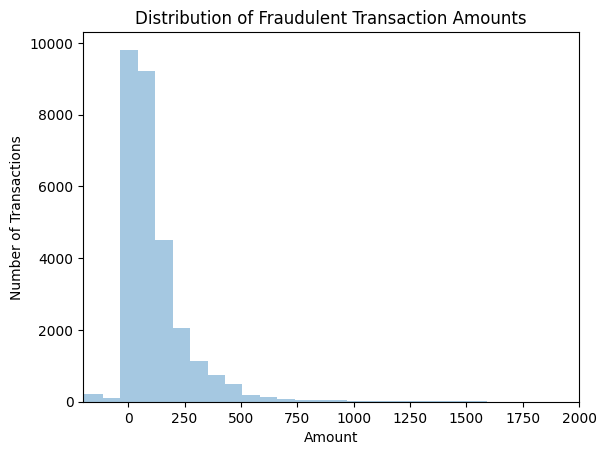

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot(fraud_data['Amount'].astype(float), kde=False, bins=80)
plt.title('Distribution of Fraudulent Transaction Amounts')
plt.xlabel('Amount')
plt.ylabel('Number of Transactions')
plt.xlim(-200, 2000)
plt.show()


The majority of fraudulent transactions' amount range from 0 to 250, indicating a prevalence of fraud in smaller-value transactions.

### (2) Geographical Distribution <a class="anchor"  id="geo"></a>

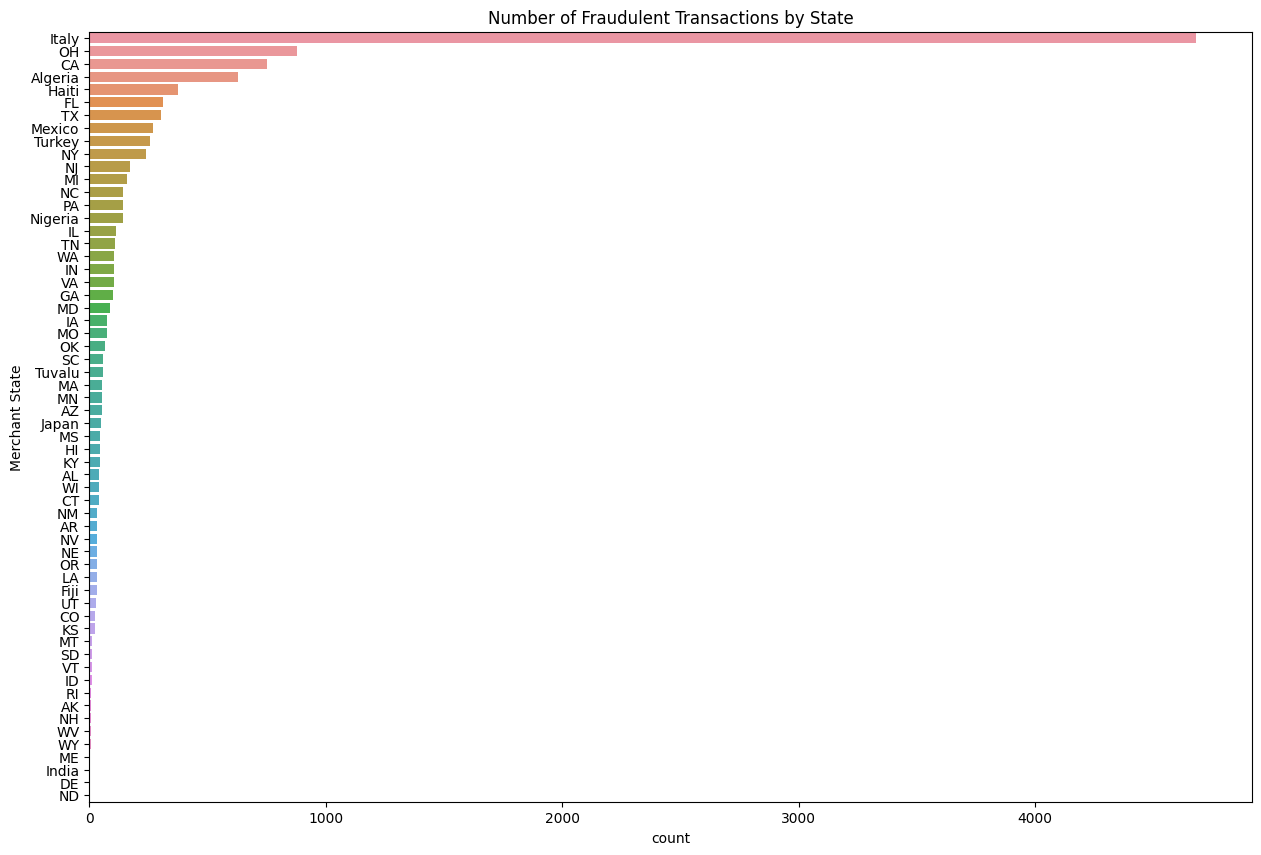

In [15]:
plt.figure(figsize=(15, 10))  
sns.countplot(data=fraud_data, y='Merchant State', order=fraud_data['Merchant State'].value_counts().index)
plt.title('Number of Fraudulent Transactions by State')
plt.show()

The State contains a mix of US states and other countries, highlighting clear geographical distinctions.

- At the country level, Italy, Algeria, Haiti, and Mexico are the major hotspot for fraudulent activities. 
- Among US states, Ohio, California, and Florida records the highest incidences of fraud.

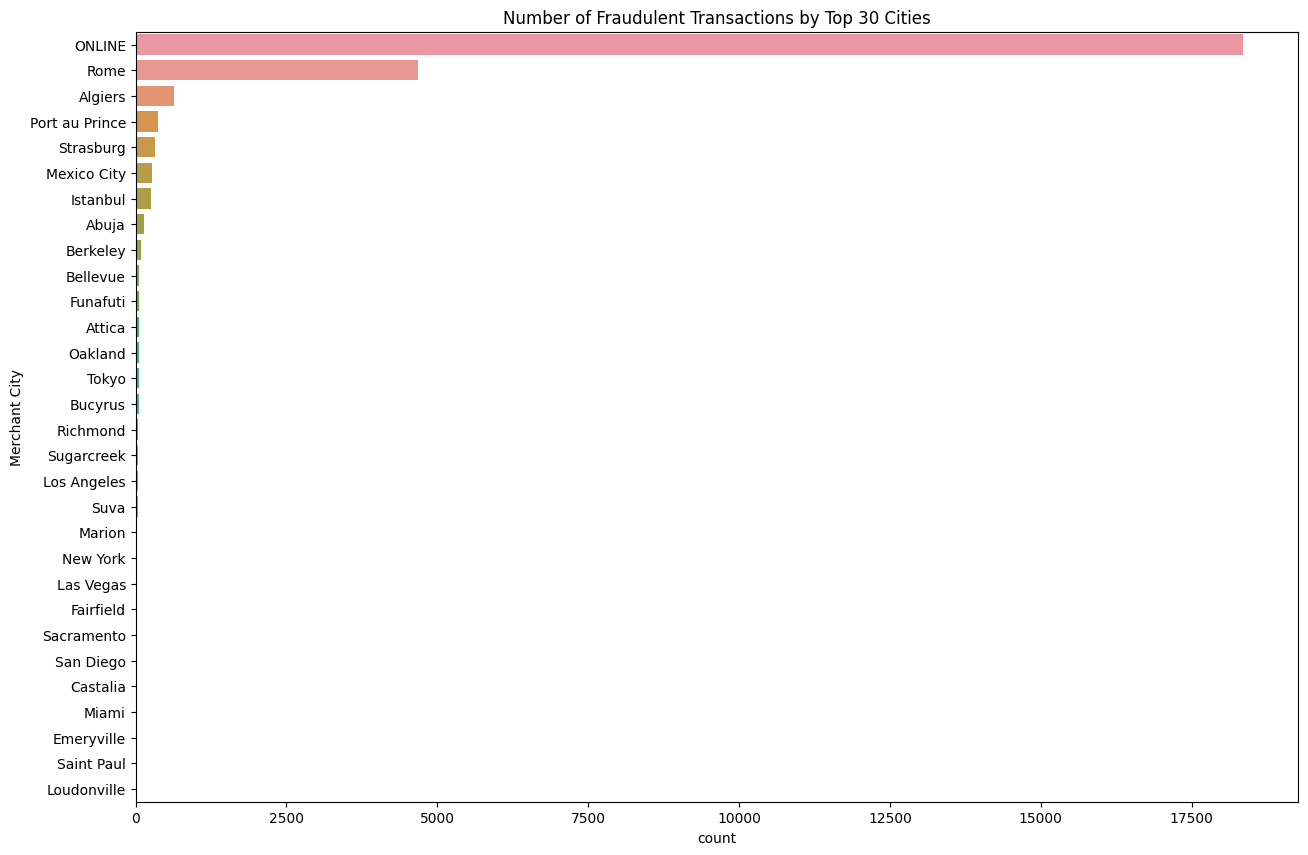

In [16]:
plt.figure(figsize=(15, 10))
top_cities = fraud_data['Merchant City'].value_counts().head(30).index
sns.countplot(data=fraud_data, y='Merchant City', order=top_cities)
plt.title('Number of Fraudulent Transactions by Top 30 Cities')
plt.show()


Online transactions are the primary venues where fraud predominantly occurs. Additionally, cities such as Rome, Algiers, and Port-au-Prince are notable hotspots for high frequencies of fraudulent activities.

### (3) Time Variation <a class="anchor"  id="time"></a>

**By year**

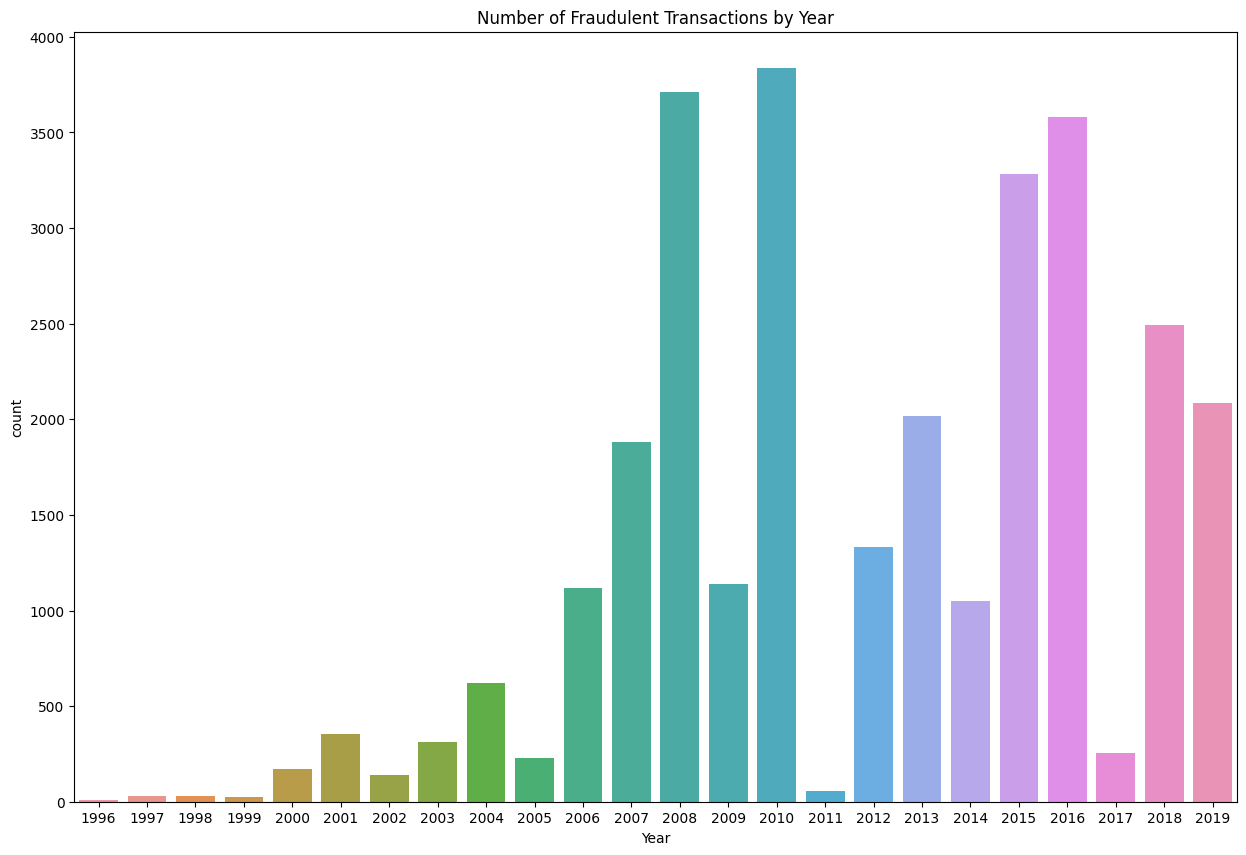

In [17]:
plt.figure(figsize=(15, 10))
sns.countplot(data=fraud_data, x='Year')
plt.title('Number of Fraudulent Transactions by Year')
plt.show()


Entering the 21st century, the number of fraud cases has been steadily rising year by year, reaching its peak in 2007-2008 during the Great Recession.

**By month**

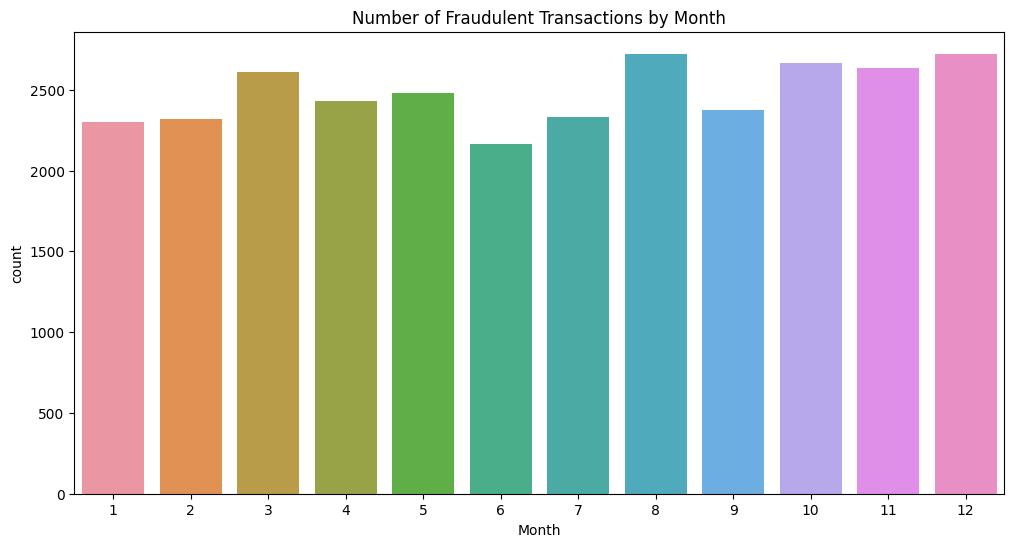

In [18]:
plt.figure(figsize=(12, 6))
sns.countplot(data=fraud_data, x='Month')
plt.title('Number of Fraudulent Transactions by Month')
plt.show()


The distribution of fraud cases across months doesn't show significant variations; however, there is a slight uptick in the number of fraud activities towards the end of year.

**By day of month**

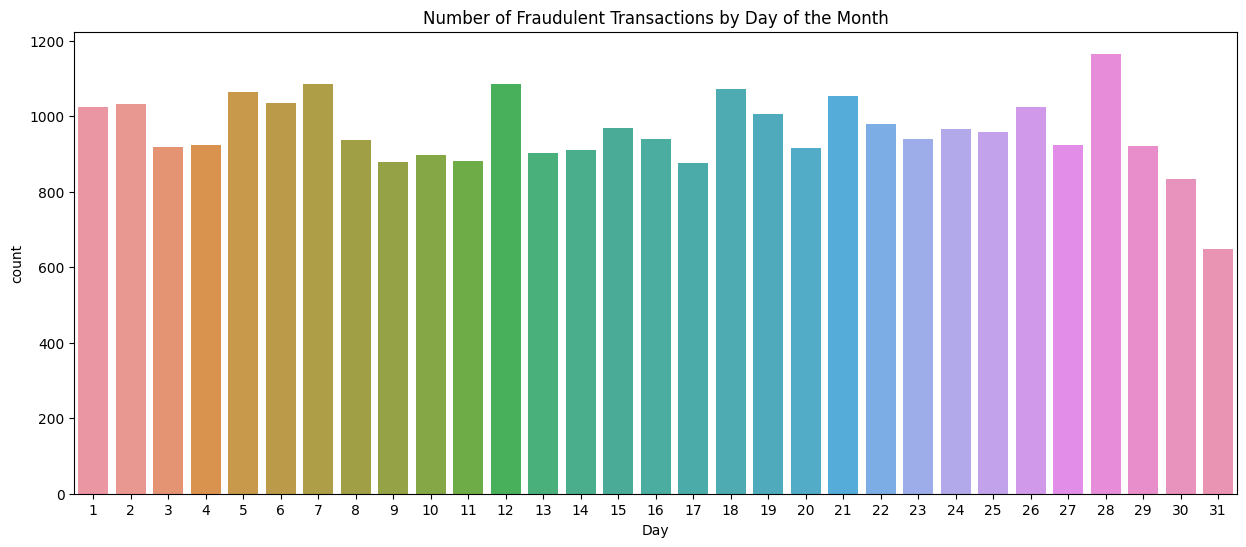

In [19]:
plt.figure(figsize=(15, 6))
sns.countplot(data=fraud_data, x='Day')
plt.title('Number of Fraudulent Transactions by Day of the Month')
plt.show()


The spread of fraud cases over the days of the month remains relatively consistent, but there's a minor increase in fraudulent activities as the month draws to a close.

**By day of week**

In [8]:
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

# Extract day of the week and map it to its name
days = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
df['Day of Week'] = df['Date'].dt.dayofweek.map(days)

fraud_data = df[df['Is Fraud?'] == 1]

# # Visualize
# plt.figure(figsize=(10, 6))
# sns.countplot(data=fraud_data, x='Day of Week', order=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], palette="Blues_d")
# plt.title('Number of Fraudulent Transactions by Day of the Week')
# plt.show()


A higher number of fraud activities occur on Sundays.

**By hour of day**

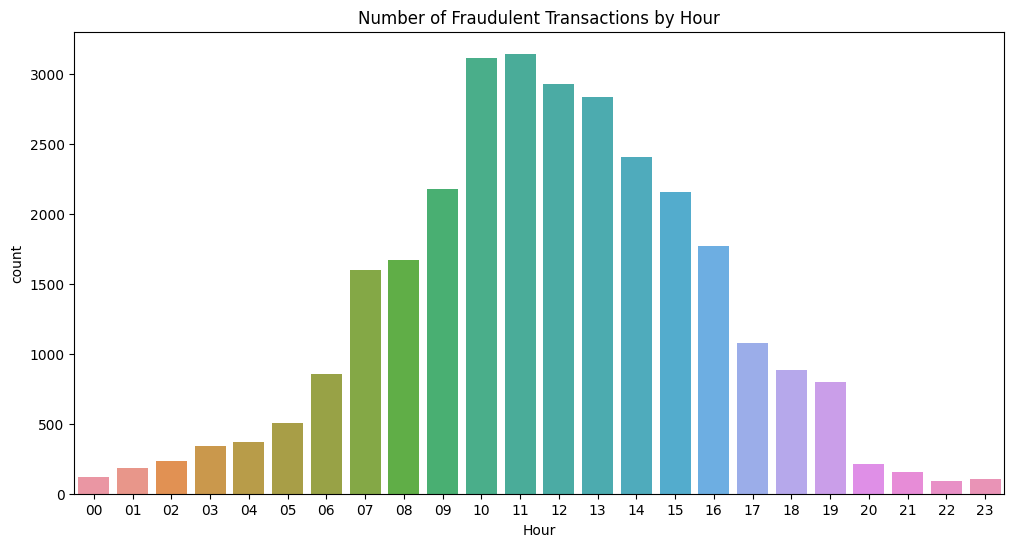

In [21]:
plt.figure(figsize=(12, 6))
sns.countplot(data=fraud_data, x='Hour', order=sorted(fraud_data['Hour'].unique()))
plt.title('Number of Fraudulent Transactions by Hour')
plt.show()


Fraud activities predominantly occur between 10 and 11 a.m. local time.

### (4) Transaction Method <a class="anchor"  id="chip"></a>

In [ ]:
sns.countplot(data=fraud_data, x='Use Chip', color='lightcoral')
plt.title('Distribution of Fraudulent Transactions by Use Chip')
plt.show()


Online transactions present the most significant vulnerability to fraud.

## 4. Fraud Detection with Machine Learning <a class="anchor"  id="ml"></a>

### (1) Data Preprocessing <a class="anchor"  id="data_preprocessing"></a>

Based on the EDA above, we will concentrate on variables that appear to exert a more significant impact on the likelihood of a case being fraudulent. Eliminating the variables with high percentage of missing value, we've chosen the following variables for modelling:

**<span style="color:#007d79;">Year, Day of Week, Hour, Amount, Use Chip, Merchant Name, Merchant City, MCC.</span>** 

In [9]:
# Subset specific columns
columns_to_select = ['Year', 'Day of Week', 'Hour', 'Amount', 'Use Chip', 'Merchant Name', 'MCC', 'Is Fraud?']
df = df[columns_to_select]

In [10]:
from sklearn.preprocessing import StandardScaler
import category_encoders as ce

def clean(df):
    # Convert data type
    df['Hour'] = df['Hour'].astype('float')
    
    # Scale the "Amount" column
    scaler = StandardScaler()
    df['Amount'] = scaler.fit_transform(df[['Amount']])
   
    # Binary encoding for categorical variables
    cat_col = ['Use Chip', 'Day of Week']
    for col in cat_col:
        if col in df.columns:
            be = ce.BinaryEncoder(drop_invariant=False)
            enc_df = pd.DataFrame(be.fit_transform(df[col]), dtype='int8')
            df = pd.concat([df, enc_df], axis=1)
            df.drop([col], axis=1, inplace=True)
    
    for col in df.columns:
        df[col] = df[col].astype(float)
        
    return df

# Create the pipeline
preprocessing_pipeline = Pipeline([
    ('cleaning', FunctionTransformer(clean, validate=False)), 
], verbose=True)

df_transformed = preprocessing_pipeline.fit_transform(df)


[Pipeline] .......... (step 1 of 1) Processing cleaning, total= 1.5min


In [17]:
df_transformed.shape

(24386900, 11)

In [24]:
df_transformed.describe().to_csv('dft.csv')

In [28]:

df_transformed.describe()

,Year,Hour,Amount,Merchant Name,MCC,Is Fraud?,Use Chip_0,Use Chip_1,Day of Week_0,Day of Week_1,Day of Week_2
count,2.438690e+07,2.438690e+07,2.438690e+07,2.438690e+07,2.438690e+07,2.438690e+07,2.438690e+07,2.438690e+07,2.438690e+07,2.438690e+07,2.438690e+07
mean,2.011955e+03,1.241420e+01,-6.103787e-16,-4.769230e+17,5.561171e+03,1.220204e-03,3.690841e-01,8.887427e-01,5.721622e-01,5.712460e-01,5.719451e-01
std,5.105921e+00,5.065882e+00,1.000000e+00,4.758940e+18,8.793154e+02,3.491011e-02,4.825568e-01,3.144505e-01,4.947652e-01,4.948980e-01,4.947968e-01
min,1.991000e+03,0.000000e+00,-6.627873e+00,-9.222899e+18,1.711000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.008000e+03,9.000000e+00,-4.198123e-01,-4.500543e+18,5.300000e+03,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.013000e+03,1.200000e+01,-1.645161e-01,-7.946765e+17,5.499000e+03,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
75%,2.016000e+03,1.600000e+01,2.612213e-01,3.189517e+18,5.812000e+03,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
max,2.020000e+03,2.300000e+01,1.505304e+02,9.223292e+18,9.402000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


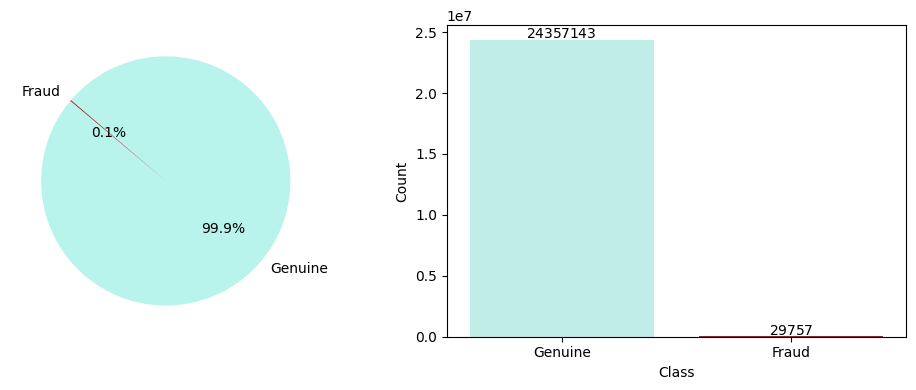

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data
labels=["Genuine","Fraud"]
fraud_or_not = df_transformed["Is Fraud?"].value_counts().tolist()
values = [fraud_or_not[0], fraud_or_not[1]]

# Matplotlib Pie Chart
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pie(values, labels=labels, colors=["#b8f4ec", "#a31626"], autopct='%1.1f%%', startangle=140)

# Seaborn Count Plot
plt.subplot(1, 2, 2)
ax = sns.countplot(x='Is Fraud?', data=df_transformed, palette=["#b8f4ec", "#a31626"])
plt.xlabel('Class')
plt.ylabel('Count')
for p in ax.patches:
    ax.annotate('${'+f'{int(p.get_height()):d}'+'}$', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 4), 
                textcoords = 'offset points')

# Set x-axis labels
ax.set_xticklabels(labels)

# Show plots
plt.tight_layout()
# Save the plot to a PDF file
plt.savefig('plot1.pdf')

# Show the plot (optional)
plt.show()


In [42]:
df_transformed['Is Fraud?'].value_counts()

Is Fraud?
0.0    24357143
1.0       29757
Name: count, dtype: int64

### (2) Under sampling

Due to limitation of computational capacity, I subset 40000 data with 20% of them being fraud cases in order to balance the proportion and ensure model performance.

In [11]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

# Split the dataset into features (X) and target variable (y)
X = df_transformed.drop(columns=['Is Fraud?'])
y = df_transformed['Is Fraud?']


In [37]:
# Create RandomUnderSampler with the desired sampling strategy
rus = RandomUnderSampler(random_state=1613)

# Apply random undersampling to the original dataset
X_resampled, y_resampled = rus.fit_resample(X, y)

# Split the resampled data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=1613)

In [3]:
X_resampled = pd.read_csv('/kaggle/input/myowndataset/X_resampled_rus.csv')
y_resampled = np.load('/kaggle/input/ytrainfraud/y_resampled_rus.npy')

# Split the resampled data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=1613)

In [102]:
X_resampled

,Year,Hour,Amount,Merchant Name,MCC,Use Chip_0,Use Chip_1,Day of Week_0,Day of Week_1,Day of Week_2
0,2019.0,6.0,0.284142,-3.345937e+18,7538.0,1.0,1.0,1.0,1.0,1.0
1,2015.0,14.0,0.168564,-6.458444e+18,4784.0,1.0,0.0,1.0,0.0,0.0
2,2011.0,23.0,-0.513445,-6.571010e+18,5499.0,0.0,1.0,1.0,1.0,1.0
3,2005.0,3.0,0.432150,-3.693651e+18,4814.0,0.0,1.0,1.0,0.0,1.0
4,2011.0,23.0,0.063227,8.384250e+17,4814.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
59509,2016.0,10.0,-0.516737,6.455213e+18,5815.0,1.0,0.0,0.0,0.0,1.0
59510,2016.0,12.0,0.890318,8.226479e+17,5311.0,1.0,0.0,0.0,0.0,1.0
59511,2016.0,12.0,3.856947,8.080935e+18,5310.0,1.0,0.0,0.0,0.0,1.0
59512,2016.0,13.0,3.753560,-4.282467e+18,4829.0,1.0,0.0,0.0,0.0,1.0


In [40]:
X_resampled.to_csv('X_resampled_rus.csv', index=False)

# Save y_resampled as a NumPy binary file
np.save('y_resampled_rus.npy', y_resampled)

In [14]:
y_resampled.value_counts()

Is Fraud?
0.0    29757
1.0    29757
Name: count, dtype: int64

In [20]:
from tqdm import tqdm

In [21]:
# Modeling with Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
# , n_estimators=200, max_depth=30, min_samples_split=10,
rf_classifier = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_classifier.fit(X_train, y_train)

# Stratified K-Fold for handling imbalanced data
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
scores = cross_val_score(rf_classifier, X_test, y_test, cv=skf, scoring='f1')
print("Cross-validation scores:", scores)
print("Average score:", scores.mean())

Cross-validation scores: [0.9043629  0.90162037 0.89531521 0.89924725 0.89918888]
Average score: 0.8999469215900753


In [5]:
# Hyperparameter tuned of RUS :'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200
                    
# Modeling with Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
# , n_estimators=200, max_depth=30, min_samples_split=10,
rf_classifier = RandomForestClassifier(class_weight='balanced', bootstrap= False, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200, random_state=42)
rf_classifier.fit(X_train, y_train)

# Stratified K-Fold for handling imbalanced data
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
scores = cross_val_score(rf_classifier, X_test, y_test, cv=skf, scoring='f1')
print("Cross-validation scores:", scores)
print("Average score:", scores.mean())

Cross-validation scores: [0.90463843 0.9088812  0.89663115 0.90008638 0.90354161]
Average score: 0.9027557548438324


In [22]:
# Hyperparameters Tuning
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [78]:

# Define the hyperparameters
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 20, 30],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create a RandomForestClassifier model
rf = RandomForestClassifier(class_weight='balanced',random_state=42)

# GridSearchCV 
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=0, scoring='f1_macro') 

grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Use the best estimator for predictions or further work
best_rf = grid_search.best_estimator_

y_pred_best_rf = best_rf.predict(X_test)

print("Random Forest Classifier Results with Best Hyperparameters:")
print(classification_report(y_test, y_pred_best_rf))
print(confusion_matrix(y_test, y_pred_best_rf))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Best hyperparameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Random Forest Classifier Results with Best Hyperparameters:
              precision    recall  f1-score   support

         0.0       0.91      0.94      0.93      8981
         1.0       0.94      0.91      0.92      8874

    accuracy                           0.93     17855
   macro avg       0.93      0.93      0.93     17855
weighted avg       0.93      0.93      0.93     17855

[[8446  535]
 [ 801 8073]]


In [45]:
import pickle

# Save to file in the current working directory
pkl_filename = "best_rf_rus.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(rf_classifier, file)

### TomekLinks

### Combined SMOTE and Tomek Links

In [15]:
from imblearn.combiallne import SMOTETomek

# Create RandomUnderSampler with the desired sampling strategy
tomeksmote = SMOTETomek()

# Apply random undersampling to the original dataset
X_resampled_tomeksmote, y_resampled_tomeksmote = tomeksmote.fit_resample(X_resampled, y_resampled)

# Split the resampled data into train and test sets
X_train_tomeksmote, X_test_tomeksmote, y_train_tomeksmote, y_test_tomeksmote = train_test_split(X_resampled_tomeksmote, y_resampled_tomeksmote, test_size=0.3, random_state=1613)

In [41]:
X_resampled_tomeksmote.to_csv('X_resampled_tomeksmote.csv', index=False)

# Save y_resampled as a NumPy binary file
np.save('y_resampled_tomeksmote.npy', y_resampled_tomeksmote)

In [17]:
X_resampled_tomeksmote.shape, y_resampled_tomeksmote.shape

((55990, 10), (55990,))

In [18]:
X_train_tomeksmote.shape, X_test_tomeksmote.shape

((39193, 10), (16797, 10))

In [19]:
# Modeling with Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
# , n_estimators=200, max_depth=30, min_samples_split=10,
rf_classifier_tomeksmote = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_classifier_tomeksmote.fit(X_train_tomeksmote, y_train_tomeksmote)

# Stratified K-Fold for handling imbalanced data
skf_tomeksmote = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
scores_tomeksmote = cross_val_score(rf_classifier_tomeksmote, X_test_tomeksmote, y_test_tomeksmote, cv=skf_tomeksmote, scoring='f1')
print("Cross-validation scores:", scores_tomeksmote)
print("Average score:", scores_tomeksmote.mean())

Cross-validation scores: [0.9244768  0.91160221 0.91827365 0.92448234 0.92415474]
Average score: 0.9205979455424618


In [20]:

# Define the hyperparameters
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 20, 30],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create a RandomForestClassifier model
rf_tomeksmote = RandomForestClassifier(class_weight='balanced',random_state=42)

# GridSearchCV 
grid_search_tomeksmote = GridSearchCV(estimator=rf_tomeksmote, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=0, scoring='f1_macro') 

grid_search_tomeksmote.fit(X_train_tomeksmote, y_train_tomeksmote)

# Get the best hyperparameters
best_params_tomeksmote = grid_search_tomeksmote.best_params_
print("Best hyperparameters:", best_params_tomeksmote)

# Use the best estimator for predictions or further work
best_rf_tomeksmote = grid_search_tomeksmote.best_estimator_

y_pred_best_rf_tomeksmote = best_rf_tomeksmote.predict(X_test_tomeksmote)

print("Random Forest Classifier Results with Best Hyperparameters:")
print(classification_report(y_test_tomeksmote, y_pred_best_rf_tomeksmote))
print(confusion_matrix(y_test_tomeksmote, y_pred_best_rf_tomeksmote))

Best hyperparameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Random Forest Classifier Results with Best Hyperparameters:
              precision    recall  f1-score   support

         0.0       0.94      0.95      0.94      8431
         1.0       0.95      0.93      0.94      8366

    accuracy                           0.94     16797
   macro avg       0.94      0.94      0.94     16797
weighted avg       0.94      0.94      0.94     16797

[[8040  391]
 [ 547 7819]]


In [22]:
# Modeling with Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
# , n_estimators=200, max_depth=30, min_samples_split=10,
rf_classifier_tomeksmote = RandomForestClassifier(class_weight='balanced',bootstrap= False, max_depth= None, min_samples_leaf= 1, min_samples_split= 5, n_estimators= 100, random_state=42)
rf_classifier_tomeksmote.fit(X_train_tomeksmote, y_train_tomeksmote)

# Stratified K-Fold for handling imbalanced data
skf_tomeksmote = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
scores_tomeksmote = cross_val_score(rf_classifier_tomeksmote, X_test_tomeksmote, y_test_tomeksmote, cv=skf_tomeksmote, scoring='f1')
print("Cross-validation scores:", scores_tomeksmote)
print("Average score:", scores_tomeksmote.mean())

Cross-validation scores: [0.9265195  0.91842346 0.92331102 0.924894   0.92854971]
Average score: 0.9243395400038891


In [42]:
import pickle

# Save to file in the current working directory
pkl_filename = "best_rf_tomeksmote.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(best_rf_tomeksmote, file)

In [27]:
from tqdm import tqdm

### (3) Predictive Modeling with Random Forest XXXXX <a class="anchor"  id="randomforest"></a>

In [30]:
# Modeling with Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

rf_classifier = RandomForestClassifier(class_weight='balanced', n_estimators=200, max_depth=30, min_samples_split=10, random_state=42)
rf_classifier.fit(X_train, y_train)

# Stratified K-Fold for handling imbalanced data
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
scores = cross_val_score(rf_classifier, X_test, y_test, cv=skf, scoring='f1')
print("Cross-validation scores:", scores)
print("Average score:", scores.mean())


Cross-validation scores: [0.80261723 0.82300885 0.81538462 0.77890011 0.81530055]
Average score: 0.8070422707443633


In [31]:
# Hyperparameters Tuning
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Suppress all warnings
warnings.simplefilter("ignore")

# Define the hyperparameters
param_grid = {
    'max_depth': [None, 20, 30],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create a RandomForestClassifier model
rf = RandomForestClassifier(n_estimators= 200, random_state=42)

# GridSearchCV 
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=0, scoring='f1_macro') 

grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Use the best estimator for predictions or further work
best_rf = grid_search.best_estimator_

y_pred_best_rf = best_rf.predict(X_test)

print("Random Forest Classifier Results with Best Hyperparameters:")
print(classification_report(y_test, y_pred_best_rf))
print(confusion_matrix(y_test, y_pred_best_rf))


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Best hyperparameters: {'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5}
Random Forest Classifier Results with Best Hyperparameters:
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97      9608
         1.0       0.93      0.77      0.84      2392

    accuracy                           0.94     12000
   macro avg       0.94      0.88      0.90     12000
weighted avg       0.94      0.94      0.94     12000

[[9466  142]
 [ 540 1852]]


In [32]:
import pickle

# Save to file in the current working directory
pkl_filename = "pickle_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(best_rf, file)

In [34]:
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)
    
# Calculate the accuracy score and predict target values
score = pickle_model.score(X_test, y_test)
print("Test score: {0:.2f} %".format(100 * score))

Test score: 94.32 %


**Interpretation:**

1. Precision: A precision of 0.93 for class 1 means that **<span style="color:#007d79;">93%</span>** of the predicted fraud cases were actually fraudulent.

2. Recall: A recall of 0.78 for class 1 means that the model identified **<span style="color:#007d79;">78%</span>** of the actual fraudulent transactions.

3. F1-score: A F1-score of **<span style="color:#007d79;">0.85</span>** indicates a good balance between precision and recall.

In summary, the model achieved high accuracy (93%) and performed well in classifying non-fraudulent transactions (class 0). However, it showed relatively lower recall (78%) for fraudulent transactions (class 1), indicating that it missed some fraudulent cases. Overall, the model demonstrates a good performance but could be further improved to better detect fraud cases.

## 5. Insights & Recommendations <a class="anchor"  id="insights"></a>

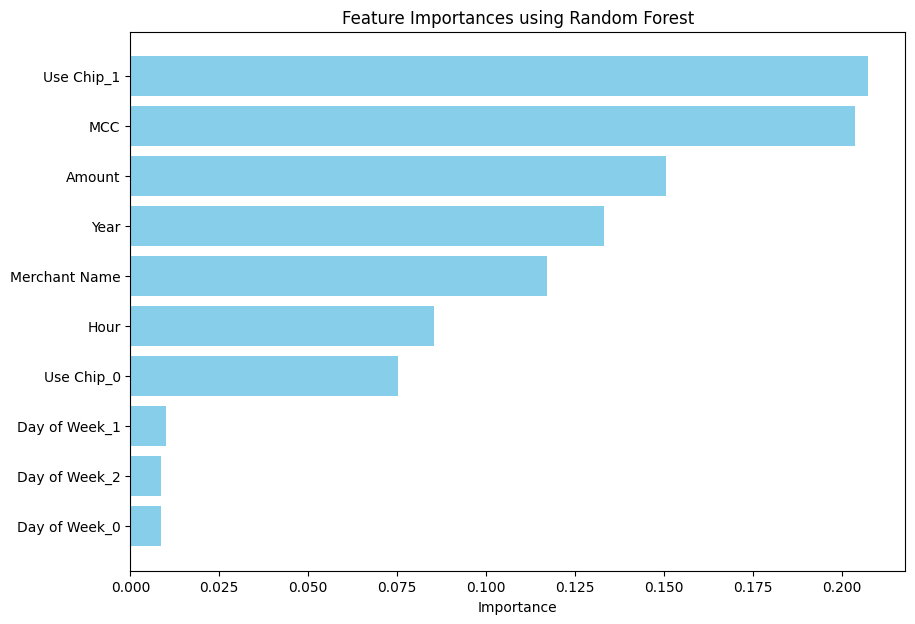

In [38]:
# Extract feature importances from the best random forest model
feature_importance = best_rf_tomeksmote.feature_importances_
features = X_train_tomeksmote.columns
#X_resampled_tomeksmote, y_resampled_tomeksmote
# Sort the feature importances and their corresponding feature names
sorted_idx = feature_importance.argsort()

# Plot horizontal bar chart
plt.figure(figsize=(10, 7))
plt.barh(features[sorted_idx], feature_importance[sorted_idx], align='center', color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances using Random Forest')
plt.show()

In [6]:
pip install dowhy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 6.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.0/299.0 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 62.9 MB/s eta 0:00:0000:010:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 59.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [37]:
X_test.loc[1018632]

Year             2.018000e+03
Hour             1.500000e+01
Amount          -4.023780e-01
Merchant Name    5.507353e+18
MCC              4.121000e+03
Use Chip_0       1.000000e+00
Use Chip_1       1.000000e+00
Day of Week_0    0.000000e+00
Day of Week_1    1.000000e+00
Day of Week_2    0.000000e+00
Name: 1018632, dtype: float64

In [38]:
from dowhy import CausalModel

model=CausalModel(
    data=df_transformed,
    treatment='MCC',
    outcome='Is Fraud?',
    common_causes=['Use Chip_1', 'Amount', 'Merchant Name']
)

In [5]:
pip install pygraphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.9/104.9 kB 2.6 MB/s eta 0:00:0000:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pygraphviz: filename=pygraphviz-1.12-cp310-cp310-linux_x86_64.whl size=96895 sha256=1e4de92051b92eaf2e1cfc3331cc45fffee899e145f5508b5cebc282be6c2e22
  Stored in directory: /root/.cache/pip/wheels/1d/ee/b5/a2f54f9e9b3951599c05dcce270ca85e472f8e6cec470e397a
Successfully built pygraphviz
Note: you may need to restart the kernel to use updated packages.


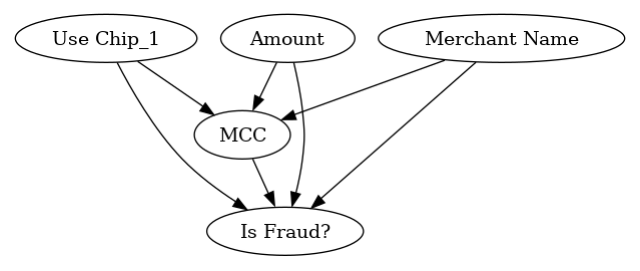

In [41]:
model.view_model()

In [42]:
identified_estimand = model.identify_effect()
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.linear_regression")
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                                 
──────(E[Is Fraud?|Merchant Name,Use Chip_1,Amount])
d[MCC]                                              
Estimand assumption 1, Unconfoundedness: If U→{MCC} and U→Is Fraud? then P(Is Fraud?|MCC,Merchant Name,Use Chip_1,Amount,U) = P(Is Fraud?|MCC,Merchant Name,Use Chip_1,Amount)

## Realized estimand
b: Is Fraud?~MCC+Merchant Name+Use Chip_1+Amount
Target units: ate

## Estimate
Mean value: 2.0348968840296715e-07



In [4]:
import pandas as pd
from dowhy import CausalModel
import itertools
from tqdm import tqdm

def estimate_causal_effect(data, treatment, outcome, common_causes):
    # Define the causal model
    model = CausalModel(
        data=data,
        treatment=treatment,
        outcome=outcome,
        common_causes=common_causes
    )
    # Identify the estimand
    identified_estimand = model.identify_effect()
    # Estimate the effect
    estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")
    return estimate.value

outcome = 'target'  # Define your outcome variable

results = []
X_resampled['target'] = y_resampled
data = X_resampled

from tqdm import tqdm

treatments = [col for col in data.columns if col != outcome]

for treatment in tqdm(treatments, desc="Processing treatments"):
    remaining_cols = [col for col in data.columns if col not in [outcome, treatment]]
    total_subsets = 2 ** len(remaining_cols) - 1
    subset_progress = tqdm(total=total_subsets, leave=False, desc=f"Subsets for {treatment}")

    for L in range(0, len(remaining_cols)+1):
        for subset in itertools.combinations(remaining_cols, L):
            subset_progress.update(1)
            try:
                effect_estimate = estimate_causal_effect(data, treatment, outcome, list(subset))
                results.append((treatment, subset, effect_estimate))
            except Exception as e:
                print(f"Error with treatment {treatment} and causes {subset}: {str(e)}")
    
    subset_progress.close()


# Sort results by the absolute value of the estimated effect to find the highest
results.sort(key=lambda x: abs(x[2]), reverse=True)

ModuleNotFoundError: No module named 'dowhy'

In [268]:
# Display top 10 results
results.sort(key=lambda x: abs(x[2]))
best_score = 0
result_i = 0
for i in range(len(results)):
    if results[i][2] > best_score:
        best_score = results[i][2]
        result_i = i

In [269]:
result_i

In [270]:
results[4863]

('Use Chip_0', ('Year',), 0.3524129840196082)

In [44]:

outcome = 'target'  # Define your outcome variable

results = []
X_resampled['target'] = y_resampled
data = X_resampled

In [7]:
ou = pd.DataFrame(y_resampled, columns=['outcome'])
df_transformed = pd.concat([X_resampled, ou], axis=1)

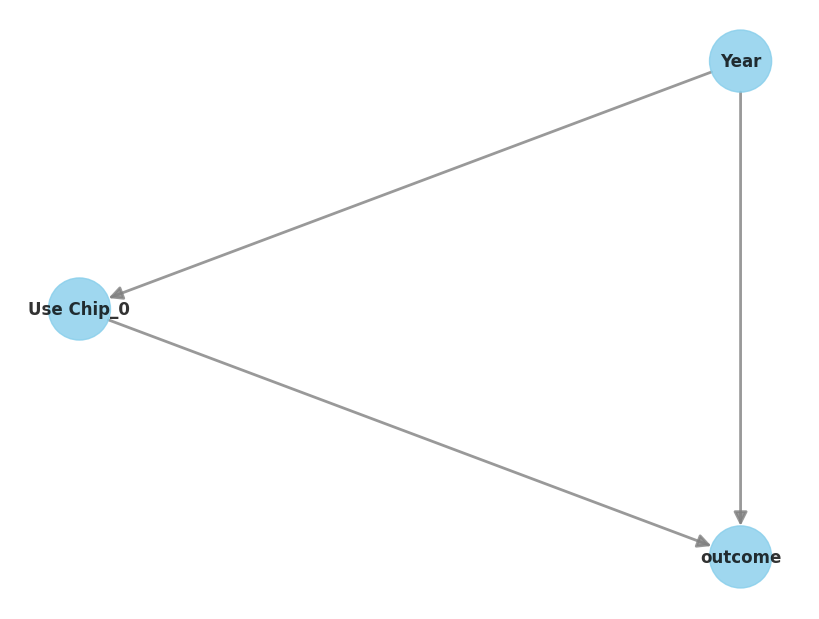

In [8]:
from dowhy import CausalModel

model = CausalModel(
    data=df_transformed,
    treatment='Use Chip_0',
    outcome='outcome',
    common_causes=['Year'],
    effect_modifiers=None
)
model.view_model(layout="dot")  # Visualizing the model can help ensure its correctness

In [9]:

# Identifying the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

# Use a causal estimation method
causal_estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression",  # Choose a method suitable for your data and model
    test_significance=True
)

print(causal_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                       
────────────(E[outcome|Year])
d[Use Chip₀]                 
Estimand assumption 1, Unconfoundedness: If U→{Use Chip_0} and U→outcome then P(outcome|Use Chip_0,Year,U) = P(outcome|Use Chip_0,Year)

## Realized estimand
b: outcome~Use Chip_0+Year
Target units: ate

## Estimate
Mean value: 0.5245487710710891
p-value: [0.]



In [294]:
X_test.loc[1018632]

Year             2.018000e+03
Hour             1.500000e+01
Amount          -4.023780e-01
Merchant Name    5.507353e+18
MCC              4.121000e+03
Use Chip_0       1.000000e+00
Use Chip_1       1.000000e+00
Day of Week_0    0.000000e+00
Day of Week_1    1.000000e+00
Day of Week_2    0.000000e+00
Name: 1018632, dtype: float64

In [10]:
import numpy as np
from scipy.optimize import minimize
from sklearn.ensemble import RandomForestClassifier


def opt(full_feature_vector, classifier, X_train):
    # Indexes for 'Use Chip_0' and 'Year' in your feature array
    index_use_chip = list(X_train.columns).index('Use Chip_0')
    index_year = list(X_train.columns).index('Year')

    # Function to calculate the model's prediction
    def model_prediction(modified_features):
        # Update the full feature vector with the modified 'Use Chip_0' and 'Year'
        full_feature_vector_copy = full_feature_vector.copy()
        full_feature_vector_copy[index_use_chip] = modified_features[0]
        full_feature_vector_copy[index_year] = modified_features[1]
        return classifier.predict_proba(full_feature_vector_copy.reshape(1, -1))[0, 1]

    # Objective function to minimize
    def objective(x_prime, x_orig):
        return np.linalg.norm(x_prime - x_orig)

    # Constraint that the prediction must be non-fraudulent
    def constraint(x_prime):
        return 0.5 - model_prediction(x_prime)

    # Initial values for 'Use Chip_0' and 'Year' from the original full feature vector
    x_orig = np.array([full_feature_vector[index_use_chip], full_feature_vector[index_year]])

    # Calculate bounds for 'Year' from the data
    min_year, max_year = X_train['Year'].min(), X_train['Year'].max()
    # Bounds for the features (assuming realistic ranges for 'Use Chip_0' and 'Year')
    bounds = [(0, 1), (min_year, max_year)]

    # Constraint setup
    cons = {'type': 'ineq', 'fun': constraint}

    # Solving the optimization problem
    result = minimize(fun=objective, x0=x_orig, args=(x_orig,), bounds=bounds, constraints=cons)
    chip0 = result.x[0]
    year = int(result.x[1])
    return chip0, year

# print("Optimal features for 'Use Chip_0' and 'Year':", chip0, year)
# print("Original features for 'Use Chip_0' and 'Year':", x_orig)

In [65]:
result.x[0], result.x[1]

In [11]:
example

array([1., 1., 1., ..., 1., 1., 0.])

In [13]:
from copy import deepcopy
example = deepcopy(X_test.iloc[0])

In [32]:
example

Year             2.017000e+03
Hour             1.800000e+01
Amount           3.823340e-02
Merchant Name   -1.642304e+18
MCC              5.912000e+03
Use Chip_0       1.000000e+00
Use Chip_1       1.000000e+00
Day of Week_0    1.000000e+00
Day of Week_1    0.000000e+00
Day of Week_2    0.000000e+00
Name: 55026, dtype: float64

In [38]:
import time

start_time = time.time()


s = opt(np.array(example), rf_classifier, X_test)

end_time = time.time()
elapsed_time = end_time - start_time

print("Elapsed time: {:.2f} seconds".format(elapsed_time))



Elapsed time: 0.18 seconds


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X

In [34]:
s

In [37]:
example['Use Chip_0'] = s[0]
example['Year'] =  s[1]
rf_classifier.predict_proba(np.array(example).reshape(1, -1))[0, 1]

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [73]:
from copy import deepcopy
example2 = deepcopy(X_test.loc[1018632])
best_rf.predict_proba(np.array(example2).reshape(1, -1))[0, 1]

In [54]:
from copy import deepcopy
data2 = deepcopy(data)
data2

,Year,Hour,Amount,Merchant Name,MCC,Use Chip_0,Use Chip_1,Day of Week_0,Day of Week_1,Day of Week_2,target
8345633,2019.0,6.0,0.284142,-3.345937e+18,7538.0,1.0,1.0,1.0,1.0,1.0,0.0
60057,2015.0,14.0,0.168564,-6.458444e+18,4784.0,1.0,0.0,1.0,0.0,0.0,0.0
13398442,2011.0,23.0,-0.513445,-6.571010e+18,5499.0,0.0,1.0,1.0,1.0,1.0,0.0
5221429,2005.0,3.0,0.432150,-3.693651e+18,4814.0,0.0,1.0,1.0,0.0,1.0,0.0
8371062,2011.0,23.0,0.063227,8.384250e+17,4814.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
9684115,2008.0,7.0,-0.478577,-3.395539e+18,5311.0,0.0,1.0,1.0,0.0,0.0,1.0
8239738,2008.0,11.0,0.144912,-2.916543e+18,5719.0,1.0,0.0,1.0,0.0,1.0,1.0
96297,2016.0,13.0,-0.084782,6.306879e+18,7542.0,1.0,1.0,0.0,0.0,1.0,1.0
13537847,2014.0,12.0,1.288014,-5.631575e+17,5310.0,0.0,1.0,1.0,1.0,1.0,1.0


In [11]:
data = data.drop(columns=['target'])
data.head()

NameError: name 'data' is not defined

Year             2.019000e+03
Hour             6.000000e+00
Amount           2.841419e-01
Merchant Name   -3.345937e+18
MCC              7.538000e+03
Use Chip_0       1.000000e+00
Use Chip_1       1.000000e+00
Day of Week_0    1.000000e+00
Day of Week_1    1.000000e+00
Day of Week_2    1.000000e+00
Name: 8345633, dtype: float64

In [61]:
best_rf.predict_proba(np.array(example_to_modify).reshape(1, -1))[0, 1]

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import os

# Parameters of the network
epsilon = 0.1
lamb = 0.02
iter_epoch = 10
sub_epoch = 6
tau = 1
train_flag = 1


train_data = torch.tensor(X_train.values, dtype=torch.float32)
train_targets = torch.tensor(y_train, dtype=torch.long)
test_data = torch.tensor(X_test.values, dtype=torch.float32)
test_targets = torch.tensor(y_test, dtype=torch.long)


# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(train_data, train_targets)
test_dataset = TensorDataset(test_data, test_targets)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # Batch size of 1 for individual attack generation


In [12]:

# Get the total number of elements in the DataLoader
total_elements = len(test_loader.dataset)
print("Total elements in the DataLoader:", total_elements)

Total elements in the DataLoader: 17855


In [105]:
# Hyperparameter tuned of RUS :'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200



X_train_attack, X_test_attack, y_train_attack, y_test_attack = train_test_split(X_test, y_test, test_size=0.03, random_state=1613)
# Modeling with Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
# , n_estimators=200, max_depth=30, min_samples_split=10,
rf_classifier_attack = RandomForestClassifier(class_weight='balanced',n_estimators=200, random_state=42)
rf_classifier_attack.fit(X_train_attack, y_train_attack)

# Stratified K-Fold for handling imbalanced data
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
scores = cross_val_score(rf_classifier_attack, X_test_attack, y_test_attack, cv=skf, scoring='f1')
print("Cross-validation scores:", scores)
print("Average score:", scores.mean())

Cross-validation scores: [0.83333333 0.73267327 0.77477477 0.85714286 0.84210526]
Average score: 0.8080058991471185


In [72]:
X_test_attack

,Year,Hour,Amount,Merchant Name,MCC,Use Chip_0,Use Chip_1,Day of Week_0,Day of Week_1,Day of Week_2
20839,2017.0,17.0,0.173440,-7.063638e+18,5812.0,0.0,1.0,1.0,0.0,0.0
10795,2017.0,11.0,-0.360316,-8.826349e+18,5411.0,1.0,1.0,1.0,0.0,0.0
13568,2013.0,18.0,-0.432370,4.872445e+18,5411.0,0.0,1.0,0.0,1.0,1.0
41181,2019.0,16.0,-0.528075,3.189517e+18,5311.0,1.0,1.0,1.0,1.0,0.0
35836,2015.0,16.0,0.206358,-6.981009e+18,5411.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
58033,2008.0,7.0,0.932867,-7.258138e+18,5921.0,0.0,1.0,1.0,0.0,1.0
19531,2010.0,0.0,0.199531,-4.282467e+18,4829.0,0.0,1.0,0.0,0.0,1.0
38334,2007.0,9.0,5.271317,-6.161792e+18,3389.0,0.0,1.0,1.0,0.0,1.0
37089,2016.0,14.0,0.550411,-2.916543e+18,5719.0,1.0,0.0,1.0,0.0,1.0


In [73]:
X_test_attack.reset_index(inplace=True)

In [74]:
X_test_attack = X_test_attack.drop(columns=['index'])

In [75]:
X_test_attack.shape

In [76]:
import pandas as pd

# Convert numpy arrays to DataFrame or Series
X_test_attack_df = pd.DataFrame(columns=X_test_attack.columns)

In [77]:
import pandas as pd

# Convert numpy arrays to DataFrame or Series
X_test_attack_df_changed = pd.DataFrame(columns=X_test_attack.columns)

In [78]:
X_test_attack_df

,Year,Hour,Amount,Merchant Name,MCC,Use Chip_0,Use Chip_1,Day of Week_0,Day of Week_1,Day of Week_2


In [79]:
y_test_attack_np = np.array([])

In [80]:
y_test_attack_np_changed = np.array([])

In [81]:
y_test_attack_np

array([], dtype=float64)

In [82]:
from tqdm import tqdm
for index, row in tqdm(X_test_attack.iterrows()):
    if y_test_attack[index] == 1:
        X_test_attack_df.loc[len(X_test_attack_df)] = row
        y_test_attack_np = np.append(y_test_attack_np, 1)

536it [00:00, 1976.72it/s]


In [83]:
import warnings
warnings.filterwarnings('ignore')

In [84]:
X_test_attack_df

,Year,Hour,Amount,Merchant Name,MCC,Use Chip_0,Use Chip_1,Day of Week_0,Day of Week_1,Day of Week_2
0,2019.0,16.0,-0.528075,3.189517e+18,5311.0,1.0,1.0,1.0,1.0,0.0
1,2015.0,16.0,0.206358,-6.981009e+18,5411.0,0.0,1.0,1.0,0.0,0.0
2,2014.0,13.0,14.153770,-5.513321e+17,4411.0,1.0,0.0,1.0,1.0,1.0
3,2015.0,16.0,2.609239,-4.330877e+18,5045.0,1.0,0.0,0.0,0.0,1.0
4,2008.0,11.0,0.428737,-2.916543e+18,5719.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
274,2007.0,13.0,0.252931,5.674176e+18,5921.0,0.0,1.0,1.0,0.0,1.0
275,2008.0,7.0,0.932867,-7.258138e+18,5921.0,0.0,1.0,1.0,0.0,1.0
276,2007.0,9.0,5.271317,-6.161792e+18,3389.0,0.0,1.0,1.0,0.0,1.0
277,2016.0,14.0,0.550411,-2.916543e+18,5719.0,1.0,0.0,1.0,0.0,1.0


In [85]:
from copy import deepcopy
from tqdm import tqdm
# X_train_attack_per = deepcopy(X_train_attack)
# y_train_attack_per = deepcopy(y_train_attack)
# X_train_attack_per.reset_index(inplace=True)

# Assuming df is your DataFrame
for index, (example, label) in tqdm(enumerate(zip(X_test_attack_df.values, y_test_attack_np))):
    if label == 1:
        example = np.copy(example)  # Using np.copy instead of deepcopy
        chipzero_ch, year_ch = opt(example, rf_classifier_attack, X_test_attack_df)
        
        # Modify elements of the row directly in the numpy array
        example[5] = chipzero_ch
        example[0] = year_ch

        X_test_attack_df_changed.loc[len(X_test_attack_df_changed)] = example
        y_test_attack_np_changed = np.append(y_test_attack_np_changed, 0)

279it [37:46,  8.12s/it]


In [110]:
X_test_attack_df_changed.shape, X_test_attack_df.shape

In [109]:
# Step 1: Calculate differences
differences = X_test_attack_df_changed != X_test_attack_df

# Step 2: Count non-zero differences
num_differences = differences.values.sum()

# Step 3: Calculate percentage of differences
total_cells = X_test_attack_df_changed.size
percentage_difference = (num_differences / total_cells) * 100

print(f"Percentage of differences: {percentage_difference:.2f}%")

Percentage of differences: 15.81%


In [93]:
X_test_attack_df_changed

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [86]:
X_test_reset = X_test.reset_index()
X_test_reset

,index,Year,Hour,Amount,Merchant Name,MCC,Use Chip_0,Use Chip_1,Day of Week_0,Day of Week_1,Day of Week_2
0,55026,2017.0,18.0,0.038233,-1.642304e+18,5912.0,1.0,1.0,1.0,0.0,0.0
1,48774,2010.0,10.0,5.478577,4.552887e+18,3596.0,1.0,0.0,0.0,1.0,0.0
2,41700,2009.0,3.0,0.967370,-1.119575e+18,5045.0,1.0,0.0,0.0,0.0,1.0
3,39005,2015.0,15.0,0.168564,-4.282467e+18,4829.0,1.0,0.0,0.0,0.0,1.0
4,8766,2015.0,13.0,-0.288141,-4.282467e+18,4829.0,1.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
17850,3077,2019.0,12.0,-0.080149,-5.162038e+18,5541.0,0.0,1.0,0.0,1.0,1.0
17851,46539,2019.0,17.0,1.586225,-1.121212e+17,3509.0,1.0,1.0,1.0,1.0,0.0
17852,45891,2013.0,11.0,0.086391,-5.841929e+18,4121.0,1.0,0.0,1.0,1.0,1.0
17853,59017,2015.0,12.0,-0.335689,-8.194608e+18,3001.0,1.0,0.0,1.0,1.0,0.0


In [87]:
X_test_reset = X_test_reset.drop(columns=['index'])

In [88]:
y_test_reset = np.copy(y_test)

In [89]:
X_test_reset = X_test_reset[:800]

In [90]:
y_test_reset = y_test_reset[:800]

In [91]:
X_test_reset.shape, y_test_reset.shape

In [106]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import os

# Parameters of the network
epsilon = 0.1
lamb = 0.02
iter_epoch = 10
sub_epoch = 6
tau = 1
train_flag = 1



train_data = torch.tensor(X_train.values, dtype=torch.float32)
train_targets = torch.tensor(y_train, dtype=torch.long)
test_data = torch.tensor(X_test_attack_df.values, dtype=torch.float32)
test_targets = torch.tensor(y_test_attack_np, dtype=torch.long)


# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(train_data, train_targets)
test_dataset = TensorDataset(test_data, test_targets)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # Batch size of 1 for individual attack generation


In [107]:
rf_classifier_attack.fit(X_test_attack_df, y_test_attack_np)

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

In [96]:

class Net_B(nn.Module):
    def __init__(self):
        super(Net_B, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.batchnorm1 = nn.BatchNorm1d(16)
        self.dropout1 = nn.Dropout(p=0.5)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.batchnorm2 = nn.BatchNorm1d(32)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(320, 64)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(64, 2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = self.conv1(x)
        x = self.relu(x)
        x = self.batchnorm1(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.batchnorm2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x
    
# Function to perform FGSM attack
def fgsm_attack(data, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_data = data + epsilon * sign_data_grad
    return perturbed_data

# Initialize networks and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net_B = Net_B().to(device)
optimizer_B = optim.SGD(net_B.parameters(), lr=0.01, momentum=0.9)

In [97]:
# Function to perform feature perturbation for random forests
def feature_perturbation(data, epsilon):
    perturbed_data = data + epsilon * np.random.randn(*data.shape)
    return perturbed_data

In [98]:
device

device(type='cuda')

In [99]:

# Populate dictionary from test_loader for training Net_B
Data_Dict = {}
Label_Dict = {}
for i, (data, labels) in enumerate(test_loader):
    Data_Dict[i+1] = data.to(device)
    Label_Dict[i+1] = labels.to(device)

In [17]:
from tqdm import tqdm

# Training Net_B, assuming augmentation happens here
net_B.train()
if train_flag:
    for sub_epoch_num in range(sub_epoch):
        for iter_num in tqdm(range(iter_epoch)):
            for i in Data_Dict:
                data = Data_Dict[i]
                target = Label_Dict[i]
                data.requires_grad = True
                optimizer_B.zero_grad()
                output = net_B(data)
                loss = F.nll_loss(output, target)
                loss.backward()
                data_grad = data.grad.data
                perturbed_data = fgsm_attack(data, lamb * (-1)**(sub_epoch_num // tau), data_grad)
                output = net_B(perturbed_data)
                loss = F.nll_loss(output, target)
                loss.backward()
                optimizer_B.step()

100%|██████████| 10/10 [10:16<00:00, 61.68s/it]


In [19]:
import warnings
warnings.filterwarnings('ignore')


In [20]:

# Modify the test function to accommodate the Random Forest model
def test(net_A, net_B, device, test_loader, epsilon):
    correct = 0
    total = 0
    sumA = 0
    sumB = 0
    trans = 0
    count = 0
    net_B.eval()
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        total += target.size(0)
        count += 1

        # Test model A accuracy
        output_A = net_A.predict(data.detach().cpu().numpy())  # Detach tensor and then predict using Random Forest

        pred_A = torch.tensor(output_A, dtype=torch.long, device=device)
        sumA += pred_A.eq(target.view_as(pred_A)).sum().item()

        # Test model B accuracy
        output_B = net_B(data)
        pred_B = output_B.max(1, keepdim=True)[1]
        sumB += pred_B.eq(target.view_as(pred_B)).sum().item()

        # Test agreement between A and B
        trans += pred_A.eq(pred_B.view_as(pred_A)).sum().item()

        # Adversarial attack test
        data.requires_grad = True
        output = net_B(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        data_grad = data.grad.data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        output = net_A.predict(perturbed_data.detach().cpu().numpy())  # Detach tensor and then predict using Random Forest

        final_pred = torch.tensor(output, dtype=torch.long, device=device)
        correct += final_pred.eq(target.view_as(final_pred)).sum().item()

    print('the number of test set: ', total)
    print('accuracy model A: ', sumA / total)
    print('accuracy model B: ', sumB / total)
    print('accuracy model, A = B: ', trans / total)
    print('missclassification transferability B to A: ', 1 - correct / total)

# Run testing
print('test ....')
test(rf_classifier, net_B, device, test_loader, epsilon)

test ....
the number of test set:  17855
accuracy model A:  0.9251750210025202
accuracy model B:  0.4903388406608793
accuracy model, A = B:  0.49437132455894706
missclassification transferability B to A:  0.07712125455054608


In [100]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier

# Function to perform feature perturbation for random forests
def feature_perturbation(data, epsilon):
    perturbed_data = data + epsilon * np.random.randn(*data.shape)
    return perturbed_data

# Modify the test function to accommodate the Random Forest model
def test(rf_classifier, rf_cl_attacker, test_loader, epsilon):
    correct = 0
    total = 0
    sumA = 0
    sumB = 0
    trans = 0
    count = 0
    for data, target in tqdm(test_loader):
        total += len(target)
        count += 1
        target = target.numpy()
        # Test model A accuracy
        output_A = rf_classifier.predict(data)  # Predict using Random Forest

        pred_A = output_A
        sumA += np.sum(pred_A == target)
#         print("pred_A, target", pred_A, target)

        # Test model B accuracy
        output_B = rf_cl_attacker.predict(data)
        pred_B = output_B
#         print("pred_B, target", pred_B, target)
        sumB += np.sum(pred_B == target)

        # Test agreement between A and B
        trans += np.sum(pred_A == pred_B)

        # Adversarial attack test
        perturbed_data = feature_perturbation(data, epsilon)
        output = rf_classifier.predict(perturbed_data)  # Predict using Random Forest

        final_pred = output
        correct += np.sum(final_pred == target)

    print('the number of test set: ', total)
    print('accuracy model A: ', sumA / total)
    print('accuracy model B: ', sumB / total)
    print('accuracy model, A = B: ', trans / total)
    print('missclassification transferability B to A: ', 1 - correct / total)

# Run testing
print('test ....')
test(rf_classifier, rf_classifier_attack, test_loader, epsilon)


test ....


100%|██████████| 279/279 [00:10<00:00, 27.67it/s]

the number of test set:  279
accuracy model A:  0.21505376344086022
accuracy model B:  1.0
accuracy model, A = B:  0.21505376344086022
missclassification transferability B to A:  0.7813620071684588


In [108]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier

# Function to perform feature perturbation for random forests
def feature_perturbation(data, epsilon):
    perturbed_data = data + epsilon * np.random.randn(*data.shape)
    return perturbed_data

# Modify the test function to accommodate the Random Forest model
def test(rf_classifier, rf_cl_attacker, test_loader, epsilon):
    correct = 0
    total = 0
    sumA = 0
    sumB = 0
    trans = 0
    count = 0
    for data, target in tqdm(test_loader):
        total += len(target)
        count += 1
        target = target.numpy()
        # Test model A accuracy
        output_A = rf_classifier.predict(data)  # Predict using Random Forest

        pred_A = output_A
        sumA += np.sum(pred_A == target)
#         print("pred_A, target", pred_A, target)

        # Test model B accuracy
        output_B = rf_cl_attacker.predict(data)
        pred_B = output_B
#         print("pred_B, target", pred_B, target)
        sumB += np.sum(pred_B == target)

        # Test agreement between A and B
        trans += np.sum(pred_A == pred_B)

        # Adversarial attack test
        perturbed_data = feature_perturbation(data, epsilon)
        output = rf_classifier.predict(perturbed_data)  # Predict using Random Forest

        final_pred = output
        correct += np.sum(final_pred == target)

    print('the number of test set: ', total)
    print('accuracy model A: ', sumA / total)
    print('accuracy model B: ', sumB / total)
    print('accuracy model, A = B: ', trans / total)
    print('missclassification transferability B to A: ', 1 - correct / total)

# Run testing
print('test ....')
test(rf_classifier, rf_classifier_attack, test_loader, epsilon)


test ....


100%|██████████| 279/279 [00:09<00:00, 28.17it/s]

the number of test set:  279
accuracy model A:  0.921146953405018
accuracy model B:  1.0
accuracy model, A = B:  0.921146953405018
missclassification transferability B to A:  0.08243727598566308
